# Neural Net Regression
In this project I wrote a neural net from scratch based on a textbook description in Chapter 11 of "Elements of Statistical Learning" (Hastie, Tibshirani, Freeman, 2008). The purpose of this project was to improve my ability to turn math on the page into working code, as well as to understand the basics of neural nets on a deeper level. The neural net is very simple: one hidden layer with an adjustable number of hidden units, as well as an adjustable learning rate. An added penalty term limits the size of the weights.

First we will create some sample data. Y is generated from a sum of sigmoids (should be easy for the NN) and X is sampled from a Gaussian distribution with added Gaussian errors:

In [3]:
##First task is to sample data from gaussian distribution to get x, y and epsilon
import numpy as np
import matplotlib.pyplot as plt
import math as mt

eps = np.random.normal(0,.3,100)
X = [ np.random.normal(0,1,2) for i in range(100) ]
#add bias column

a1 = [3,3]
a2 = [3,-3]
##sigmoid function
def sigmoid(eta):
    if eta>1e2:
        return 1.0
    if eta <-1e2:
        return 0.0
    else:
        return 1/(1+mt.exp(-eta))

##derivative is just s*(1-s)
def sigmoid_grad(eta):
    return sigmoid(eta)*(1-sigmoid(eta))

##dot product function
def dot(a,b):
    tot = 0
    for i in range(len(a)):
        tot = tot+(a[i]*b[i])
        
    return(tot) 
    
##calculate Ys - sum of sigmoids
def calcY(a1,a2,x,eps,n):
    
    return [(sigmoid(dot(a1,x[i])) + sigmoid(dot(a2,x[i])) + eps[i]) for i in range(n) ]

Y = calcY(a1,a2,X,eps,100)

## Create the layers 
Now we will create the layers of the function. Z is the hidden layer, which transforms the input data using a sigmoid function and a specified number of hidden units. A linear combination of the transformed inputs gives us the T layer value, which in the case of regression is compared directly to our output for error calculation. For classification, the T value would be transformed using the softmax function into a value f(X).

In [4]:
#function that computes Z_mis. non-linear
def Zfunc(alpha,x,M):
    
    ##eta stores the arguments for sigmoid function in length M vectors for data point j
    eta = [[] for i in range(len(x))]
    ##this fills in the eta vector
    for j in range(len(x)):
        eta[j] = [alpha[m][0]+dot(alpha[m][1:],x[j]) for m in range(M)]
    
    ##calculates z using eta and sigmoid. stores in length M vectors for data point i
    z = [[sigmoid(eta[i][m]) for m in range(M)] for i in range(len(x))]
    #print(z[0][0])
    return z

##function that computes T_kis. This step is linear
def Tfunc(beta,z,K):
    T = [[] for i in range(len(z))]
    #cycles through class j of k and creates T_ks for each data i in z
    for i in range(len(z)):
        T[i] = [beta[k][0]+dot(beta[k][1:],z[i]) for k in range(K)]
    
    return T

##function that normalizes T - would only use for classification
def softmax(K,T):
    if K ==0:
        K = 1
    #tot =0
    #for i in range(K):
        #tot = tot + mt.exp(T[i])
    g = [mt.exp(T[k])/1 for k in range(K)]
    return g

def softmax_grad(K,T):
    g = softmax(K,T)
    return [g[i]*(1- g[i]) for i in range(len(g))]
##function that computes f_kis. will output n length vector
def Ffunc(T,K):
    f = [np.zeros(K) for i in T]
    for i in range(len(T)):
        f[i] = softmax(K,T[i])
        
    return f


## Back-Propagation
The following functions use the error between the output f(x) and the data point Y to begin the back-propagation process. The Z and T layers have weights associated with hidden units and classes, respectively. These weights give us our f(X) value (the 'forward pass'), and the gradient of the error function with respect to the weights gives us updated values of the weights (the 'backward pass' or 'back-propagation'). I use a sum of squared error.

In [5]:
##function that computes error - use sum of squared errors
def Rfunc(y,f):
    error = 0
    for i in range(len(y)):
        error = error + (y[i]-f[i])**2
    return error

##add penalty to error - remember to use weight decay lambda...
def Jfunc(R, alpha, beta):
    beta_sum = 0
    alpha_sum = 0
    
    for k in range(len(beta)):
        for m in range(len(beta[0])):
            beta_sum = beta_sum + beta[m]**2
            
    for m in range(len(alpha)):
        for l in range(len(alpha[0])):
            alpha_sum = alpha_sum + alpha[l]**2
    
    return alpha_sum + beta_sum

##gradient functions for steepest descent
##gradient with respect to beta
def beta_grad(beta,y,x,M,K,f,z,T,lam):
    ##store as vector of vector of vector of ms in ks in is
    grad = [[np.zeros(M+1) for k in range(K)] for i in range(len(x))]
    ##fill er up
    for i in range(len(x)): ##each data point
        for k in range(K): ##each class
            for m in range(1,M+1): ##each unit
                #for classification: #grad[i][k][m] = 2*(y[i] - f[i])*softmax(K,T[i])[0]*z[i][m]
                grad[i][k][m] = -2*(y[i] - f[i])*z[i][m-1] +2*lam*beta[k][m-1] ##add penalty
    #print (grad[0][0])            
    return grad

##gradient with respect to alpha
def alpha_grad(alpha,beta,y,x,M,K,f,z,T,lam):
    ##store as vector of vector of ls in ms in is
    L = len(alpha[0])
    
    grad = [[np.zeros(L) for i in range(M)] for j in range(len(x))]
    ##fill er up
    Ktot  = 0
    for i in range(len(x)): ##each data point
        for m in range(1,M): ##each unit
            for l in range(1,L): ##each alpha
                Ktot = 0
                for k in range(K):
                    #for classification: #Ktot = Ktot + 2*(y[i] - f[i])*-1*softmax(K,T[i])[0]*beta[k][m]*sigmoid_grad(dot(alpha[m][1:],x[i])*x[i][l])
                    Ktot = Ktot + 2*(y[i] - f[i])*beta[k][m]*sigmoid_grad(dot(alpha[m][1:],x[i])*x[i][l-1])+2*lam*alpha[m][l] ##add penalty
                grad[i][m][l] = -Ktot
    #print(grad[0][1])
    return grad


##steepest descent 
def beta_descent(beta,x,K,M,grad,gamma):
    for k in range(K): ##each class
        for m in range(1,M+1): ##each unit
            tot = 0
            for i in range(len(x)): ##each data point 
                tot = tot + grad[i][k][m]
            beta[k][m] = beta[k][m] - gamma*tot 
    return(beta)

def alpha_descent(alpha,x,M,grad,gamma):
    L = len(alpha[0])
    for m in range(1,M):
        for l in range(1,L):
            tot = 0 
            for i in range(len(x)):##cylces through all data points
                tot = tot + grad[i][m][l]
            
            alpha[m][l] = alpha[m][l]  - gamma*tot
    return(alpha)
    
##back-propagation time. Takes data and weights as inputs and returns alpha and beta and f for error testing
def back_prop(x,y,M,K,alpha,beta,gamma,lam):
    Z = Zfunc(alpha,x, M)
    T = Tfunc(beta,Z,K)
    f = T
    a_grad = alpha_grad(alpha,beta,y,x,M,K,f,Z,T,lam) 
    b_grad = beta_grad(beta,y,x,M,K,f,Z,T,lam)
    
    alpha = alpha_descent(alpha,x,M,a_grad,gamma)
    beta = beta_descent(beta,x,K,M,b_grad,gamma)
    
    return [alpha,beta,f]

###run until you get under some specified error??
##create random alphas and betas around 0
def NN(x,y,K,M,lam):
    gamma =1e-3##learning rate- for some reason if this guy is not small we get huge and ascend
    N = len (x)
    L = len(x[0]) 
    ##initialize alpha and beta and z and t and f
    alpha = (np.random.rand(M,L+1)-.5)
    beta = (np.random.rand(K,M+1)-.5)
    ##start with looping a couple times
    for i in range(1000):
        theta = back_prop(x,y,M,K,alpha,beta,gamma,lam)
        alpha =theta[0]
        #print(Zfunc(alpha,X,M)[2])
        #print(alpha[3])
        beta =theta[1]
        #print(beta[0])
        err  = Rfunc(y,theta[2])
        if i%50==0:
            print(err)
        
    return [err,theta]


## Results and plots
We are now going to verify that steepest descent is working using test data, and create some visualizations. The error should be shrinking...

In [6]:
result = NN(X,Y,1,2,.002)
#print(result[0])
##create test data
        
epsT = np.random.normal(0,.3,1000)
##create x with variance 4 and mean 0
Xtest = [ np.random.normal(0,1,2) for i in range(1000) ]
a1 = [3,3]
a2 = [3,-3]
##sigmoid functio

Ytest = calcY(a1,a2,Xtest,epsT,100)

def Test(X,Y,theta,K,M):
    alpha =theta[0]
    beta = theta[1]
    Z = Zfunc(alpha,X, M)
    T = Tfunc(beta,Z,K)
    f = T
    err = Rfunc(Y,f)
    #print err
    return [err,f]

[146.82450226]
[35.96639179]
[33.63977588]
[31.57549502]
[29.69962895]
[28.03320923]
[26.58006547]
[25.32676405]
[24.2456586]
[23.29976033]
[22.44973774]
[21.66132166]
[20.9100818]
[20.18205458]
[19.47150162]
[18.77826928]
[18.10619936]
[17.46242347]
[16.85661543]
[16.29956812]


The error is descending, so the neural net appears to be working. Now we will create some functions for visualization. We will show the prediction surface and the data in 3-dimensions. The function "AnimateNN" creates plots that show the development of the neural net prediction surface. I turned these images into a gif which is included in the repository.

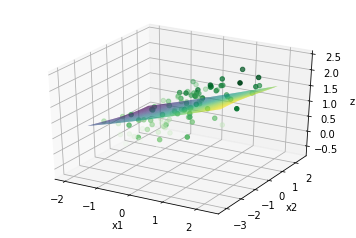

In [7]:
from mpl_toolkits import mplot3d
##map test data
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([X[i][0] for i in range(len(X))],[X[i][1] for i in range(len(X))],Y, c=Y,cmap='Greens')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('z')

x1plot = np.linspace(-2,2,100)
x2plot = np.linspace(-2,2,100)
X1,X2 = np.meshgrid(x1plot,x2plot)
combos = [[] for i in range(100)]
for i in range(100):
    combos[i] = [ [X1[i][j],X2[i][j]] for j in range(100)]
##this creates combos as data points

##this should just output predictions based on inputs
def fplot(X,theta,K,M):
    alpha =theta[0]
    beta = theta[1]
    Z = Zfunc(alpha,X, M)
    T = Tfunc(beta,Z,K)
    f = T
    return f

#poop = fplot(combos[1],result[1],1,2)
f_plot = [fplot(combos[i],result[1],1,2) for i in range(100)]
#this reshapes the data
for i in range(100):
    f_plot[i] = [f_plot[i][j][0] for j in range(100)]
#now convert from list to array
f_plot = np.asarray(f_plot)
ax.plot_surface(X1,X2,f_plot,rstride=1, cstride=1,cmap='viridis', edgecolor='none')

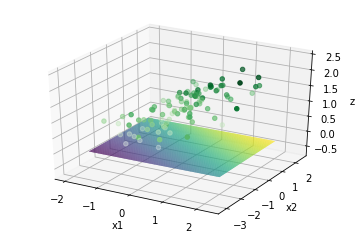

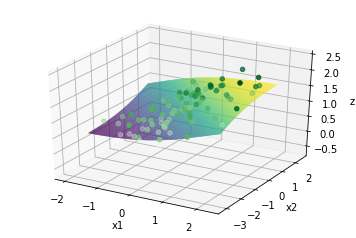

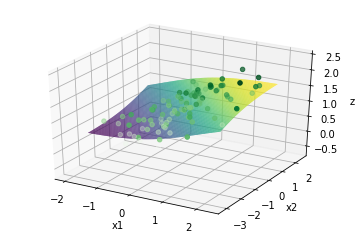

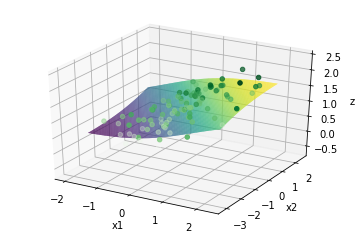

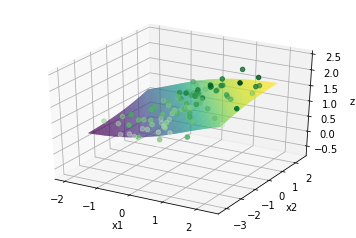

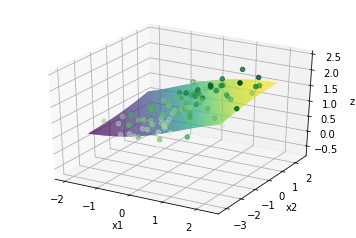

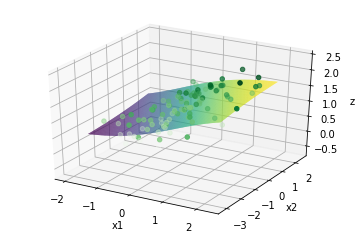

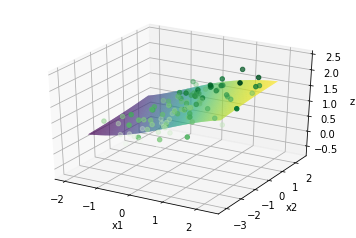

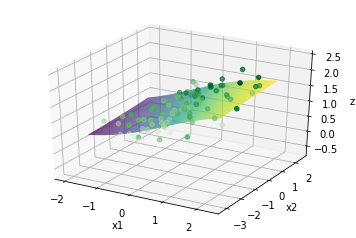

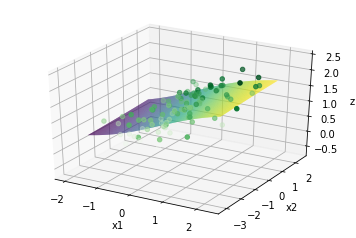

In [8]:
def animateNN(x,y,K,M,lam):
    gamma =1e-3##learning rate- for some reason if this guy is not small we get huge and ascend
    L = len(x[0]) 
    ##initialize alpha and beta and z and t and f
    alpha = (np.random.rand(M,L+1)-.5)
    beta = (np.random.rand(K,M+1)-.5)
    ##plot thy data
                                                                                                                                   
    
    for i in range(500):
        theta = back_prop(x,y,M,K,alpha,beta,gamma,lam)
        alpha =theta[0]
        
        beta =theta[1]
        if np.mod(i,50)==0:
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.scatter3D([X[i][0] for i in range(len(X))],[X[i][1] for i in range(len(X))],Y, c=Y,cmap='Greens')
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            ax.set_zlabel('z')
            
            x1plot = np.linspace(-2,2,100)
            x2plot = np.linspace(-2,2,100)
            X1,X2 = np.meshgrid(x1plot,x2plot)
            combos = [[] for i in range(100)]
            for i in range(100):
                combos[i] = [ [X1[i][j],X2[i][j]] for j in range(100)]
                
            f_plot = [fplot(combos[i],theta,1,2) for i in range(100)]
            #this reshapes the data
            for i in range(100):
                f_plot[i] = [f_plot[i][j][0] for j in range(100)]
            #now convert from list to array
            f_plot = np.asarray(f_plot)
            ax.plot_surface(X1,X2,f_plot,rstride=1, cstride=1,cmap='viridis', edgecolor='none')
            
        
    return 

animateNN(X,Y,1,2,.002)

# Conclusions
This project allowed me to get a grasp on the basics of neural nets and to demonstrate the ability to turn math into code. The visualizations are a helpful tool for understanding multivariate regression. Some improvements I could make include increasing the speed of the solver and including an adjustable number of hidden layers.